In [1]:
import os
import pandas as pd
import numpy as np
import quantstats as qs
from typing import Dict
import datetime as dt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [24]:
########## Parameters class 
####Core principals to be decided once and not changed through out the strategy

# 15 mins ORB
# enter a spread on either side which is tested first


class Params():
    def __init__(self) -> None:
    # Non changeable parameters
        self.Period = "15 mins"
        self.strike_chng = 5
        self.lot_size = 100
        self.ref_atm = 0
        self.ref_time = None
        self.period_high = 0
        self.period_low = 0 
        self.start_ORB_time = dt.time(9,31)
        self.end_ORB_time = dt.time(10)
        self.entry_time = dt.time(9,45)
        self.max_lots = 0
        self.net_credit = 0
        self.sid = 1
        self.enter_spread = False
        self.enter_condor = False


    # Changeable parameters
        self.strikes_away = 15
        self.strategy_stoploss = 0
        self.square_off_time = dt.time(15)


class Single_leg():
    def __init__(self):
        self.strike = 0
        self.bs = 0
        self.status = 0
        self.open_px = 0
        self.close_px = 0
        self.open_time = 0
        self.close_time = 0
        self.lots = 0


class Condor():
    def __init__(self) -> None:
        self.atm_strike = 0
        self.call_sell = Single_leg()
        self.put_sell = Single_leg()
        self.call_buy = Single_leg()
        self.put_buy = Single_leg()
        self.condor_status = 0
        self.net_credit = 0
        self.max_loss = 0
        self.max_profit = 0

class Vertical_spread():
    def __init__(self) -> None:
        self.atm_strike = 0
        self.opt_type = ""
        self.sell_leg = Single_leg()
        self.buy_leg = Single_leg() 
        self.spread_status = 0
        self.max_loss = 0
        self.max_profit = 0
        self.net_credit = 0
        

class Position():
    def __init__(self) -> None:
        self.sid = 0
        self.open_time = None
        self.condor = Condor()
        self.spread = Vertical_spread()


        # Condor params
        
class OHLC():
    def __init__(self):
        self.df = None
        self.timeframe = 0

    def making_ohlc(self,df,timeframe):
        self.df = df
        self.timeframe = timeframe

        
        self.df = self.df.resample(timeframe,
                                origin = "start",
                                offset = "0min").agg({"undLtp": ["first","max","min","last"]})
        self.df.columns = ["Open","High","Low","Close"]

        return self.df
        


In [25]:
#### Model Functions ###
def check_orb_breakout(ohlc_df,orb_high,orb_low,end_orb_time,square_off_time):

    for i in range(len(ohlc_df) - 2):
        curr_time = ohlc_df.index[i].time()

        if curr_time > end_orb_time and curr_time < square_off_time:
            close = ohlc_df.iloc[i]['Close']
            next_close = ohlc_df.iloc[i+1]['Close']
            entry_time = ohlc_df.index[i+2].time() 

            if close > (orb_high + 2)  and next_close > (orb_high + 2):
                return True, "PUT", entry_time

            elif close < (orb_low - 2) and next_close < (orb_low - 2 ):
                return True, 'CALL', entry_time
            
    return False, None , None



In [38]:
instrument = "SPXW"
years = [2024]
# months = ["JAN","FEB","MAR","APR","MAY","JUN","JUL","AUG","SEP","OCT","NOV","DEC"]
months = ["APR"]
all_positions = []

for year in years:
    for mnth in months:
        path = r"D:\USER_DATA\Desktop\Data For testing\US Master Data\SPXW\{}\{}".format(year,mnth)
        dirlist = os.listdir(path)
        dirlist = dirlist[18:19]

        for file in dirlist:
            path = r"D:\USER_DATA\Desktop\Data For testing\US Master Data\SPXW\{}\{}\{}".format(year,mnth,file)
            print(f"\n file {file}")
            df = pd.read_feather(path)

            model_params = Params()
            positions_map:Dict[int,Position] = {}
            
            ohlc = OHLC()
            ohlc_df = ohlc.making_ohlc(df,"1min")

            for idx in df.itertuples():
                curr_time  = idx.Index.time()
                undltp = idx.undLtp
                try:
                    if model_params.start_ORB_time < curr_time < model_params.end_ORB_time:
                        if model_params.period_high == 0:
                            model_params.period_high = undltp
                        if undltp > model_params.period_high:
                            model_params.period_high = undltp
                        if model_params.period_low == 0:
                            model_params.period_low = undltp
                        if undltp < model_params.period_low:
                            model_params.period_low = undltp

                        

                    if model_params.start_ORB_time < curr_time < model_params.square_off_time:
                        # Entering an Iron condor
                        if curr_time == model_params.entry_time:
                            model_params.ref_atm = undltp
                            atm_strike = round(model_params.ref_atm/model_params.strike_chng) * model_params.strike_chng
                            model_params.ref_atm = atm_strike
                            model_params.enter_condor = True

                            if model_params.enter_condor:
                                sid = model_params.sid
                                positions_map[sid] = Position()
                                pos = positions_map[sid] 
                                pos.open_time = idx.Index
                                pos.condor.atm_strike = model_params.ref_atm
                                pos.condor.condor_status = 1
                                pos.condor.call_sell.strike = pos.condor.atm_strike + 15
                                try:
                                    pos.condor.call_sell.open_px = getattr(idx,f"C_{positions_map[sid].condor.call_sell.strike}_bid")
                                except:
                                    pos.condor.call_sell.open_px = getattr(idx,f"C_{positions_map[sid].condor.call_sell.strike}_mid")
                                pos.condor.call_sell.bs = 2
                                pos.condor.call_sell.lots = 1
                                pos.condor.call_sell.status = 1

                                pos.condor.put_sell.strike = pos.condor.atm_strike - 15
                                pos.condor.put_sell.open_px = getattr(idx,f"P_{positions_map[sid].condor.put_sell.strike}_bid")
                                pos.condor.put_sell.bs = 2
                                pos.condor.put_sell.lots = 1
                                pos.condor.put_sell.status = 1

                                pos.condor.call_buy.strike = pos.condor.call_sell.strike + 10
                                pos.condor.call_buy.open_px = getattr(idx,f"C_{positions_map[sid].condor.call_buy.strike}_ask")
                                pos.condor.call_buy.bs = 1
                                pos.condor.call_buy.lots = 1
                                pos.condor.call_buy.status = 1

                                pos.condor.put_buy.strike = pos.condor.put_sell.strike - 10
                                pos.condor.put_buy.open_px = getattr(idx,f"P_{positions_map[sid].condor.put_buy.strike}_ask")
                                pos.condor.put_buy.bs = 1
                                pos.condor.put_buy.lots = 1
                                pos.condor.put_buy.status = 1

                                pos.condor.net_credit = (pos.condor.call_sell.open_px + pos.condor.put_sell.open_px - pos.condor.call_buy.open_px - pos.condor.put_buy.open_px )
                                call_spread = (pos.condor.call_buy.strike - pos.condor.call_sell.strike)
                                put_spread = (pos.condor.put_sell.strike - pos.condor.put_buy.strike)
                                pos.condor.max_loss = ((call_spread - pos.condor.net_credit) * model_params.lot_size) + ((put_spread - pos.condor.net_credit) * model_params.lot_size)
                                pos.condor.max_profit = pos.condor.net_credit * 100
                                
                                model_params.sid += 1


                            confirmed, side, entry_time = check_orb_breakout(
                                ohlc_df,model_params.period_high,model_params.period_low,model_params.end_ORB_time,model_params.square_off_time)
                            
                            if confirmed and model_params.enter_spread == False:
                                print(f"Breakout {side}, enter at {entry_time}")

                                ## Entering spread
                                sid = model_params.sid
                                positions_map[sid] = Position()
                                pos = positions_map[sid] 
                                pos.open_time = idx.Index
                                pos.spread.spread_status = 1
                                if side == "CALL":
                                    pos.spread.opt_type = "C"
                                    pos.spread.sell_leg.strike = model_params.ref_atm + 15
                                    pos.spread.sell_leg.open_px = getattr(idx,f"{pos.spread.opt_type}_{pos.spread.sell_leg.strike}_bid")
                                    pos.spread.sell_leg.lots = 1
                                    pos.spread.sell_leg.bs = 2

                                    pos.spread.buy_leg.strike = pos.spread.sell_leg.strike + 10
                                    pos.spread.buy_leg.open_px =  getattr(idx,f"{pos.spread.opt_type}_{pos.spread.buy_leg.strike}_ask")
                                    pos.spread.buy_leg.bs = 1
                                    pos.spread.buy_leg.lots = 1

                                    pos.spread.net_credit = (pos.spread.sell_leg.open_px - pos.spread.buy_leg.open_px )
                                    pos.spread.max_loss = (((pos.spread.buy_leg.strike - pos.spread.sell_leg.strike) - pos.spread.net_credit) * model_params.lot_size)
                                    pos.spread.max_profit = pos.spread.net_credit * 100

                                if side == "PUT":
                                    pos.spread.opt_type = "P"
                                    pos.spread.sell_leg.strike = model_params.ref_atm - 15
                                    pos.spread.sell_leg.open_px = getattr(idx,f"{pos.spread.opt_type}_{pos.spread.sell_leg.strike}_bid")
                                    pos.spread.sell_leg.lots = 1
                                    pos.spread.sell_leg.bs = 2

                                    pos.spread.buy_leg.strike = pos.spread.sell_leg.strike - 10
                                    pos.spread.buy_leg.open_px =  getattr(idx,f"{pos.spread.opt_type}_{pos.spread.buy_leg.strike}_ask")
                                    pos.spread.buy_leg.bs = 1
                                    pos.spread.buy_leg.lots = 1

                                    
                                    pos.spread.net_credit = (pos.spread.sell_leg.open_px - pos.spread.buy_leg.open_px )
                                    pos.spread.max_loss = (((pos.spread.sell_leg.strike - pos.spread.buy_leg.strike) - pos.spread.net_credit) * model_params.lot_size)
                                    pos.spread.max_profit = pos.spread.net_credit * 100

                                model_params.enter_spread =  True

                    for sid, pos in positions_map.items():
                        if curr_time >= model_params.square_off_time:
                            if pos.condor.condor_status == 1:
                                pos.condor.call_sell.close_px = getattr(idx,f"C_{pos.condor.call_sell.strike}_ask")
                                pos.condor.call_sell.status = 0
                                pos.condor.call_sell.close_time = curr_time
                                
                                pos.condor.call_buy.close_px = getattr(idx,f"C_{pos.condor.call_buy.strike}_bid")
                                pos.condor.call_buy.status = 0
                                pos.condor.call_buy.close_time = curr_time

                                pos.condor.put_sell.close_px = getattr(idx,f"P_{pos.condor.put_sell.strike}_ask")
                                pos.condor.put_sell.status = 0
                                pos.condor.put_sell.close_time = curr_time
                                
                                pos.condor.put_buy.close_px = getattr(idx,f"P_{pos.condor.put_buy.strike}_bid")
                                pos.condor.put_buy.status = 0
                                pos.condor.put_buy.close_time = curr_time

                                pos.condor.condor_status = 0

                            if pos.spread.spread_status == 1:
                                if pos.spread.opt_type == "C":
                                    pos.spread.sell_leg.close_px = getattr(idx,f"{pos.spread.opt_type}_{pos.spread.sell_leg.strike}_bid")
                                    pos.spread.sell_leg.close_time = curr_time
                                    pos.spread.sell_leg.status = 0

                                    pos.spread.buy_leg.close_px = getattr(idx,f"{pos.spread.opt_type}_{pos.spread.buy_leg.strike}_ask")
                                    pos.spread.buy_leg.close_time = curr_time
                                    pos.spread.buy_leg.status = 0
                                    pos.spread.spread_status = 0

                                if pos.spread.opt_type == "P":
                                    pos.spread.sell_leg.close_px = getattr(idx,f"{pos.spread.opt_type}_{pos.spread.sell_leg.strike}_bid")
                                    pos.spread.sell_leg.close_time = curr_time
                                    pos.spread.sell_leg.status = 0

                                    pos.spread.buy_leg.close_px = getattr(idx,f"{pos.spread.opt_type}_{pos.spread.buy_leg.strike}_ask")
                                    pos.spread.buy_leg.close_time = curr_time
                                    pos.spread.buy_leg.status = 0
                                    pos.spread.spread_status = 0
                except:
                    print(f" ERROR IN file {file}")
                    pass
            all_positions.append(positions_map)          
                        



 file 25-04-2024.feather
Breakout CALL, enter at 10:02:01


In [36]:
# After your loop ends (after building all_positions):

# Flatten into list of dicts
data_dicts = []
for pos_map in all_positions:              # each pos_map is a dict {sid: Position()}
    for sid, pos in pos_map.items():
        # turn condor data into dict
        condor_dict = {}
        if hasattr(pos, "condor"):
            condor_dict = {
                "sid": sid,
                "condor_open_time": pos.open_time,
                "condor_atm_strike": pos.condor.atm_strike,
                "condor_net_credit": pos.condor.net_credit,
                "condor_max_loss": pos.condor.max_loss,
                "condor_max_profit": pos.condor.max_profit,
                "call_sell_strike": pos.condor.call_sell.strike,
                "call_sell_open_px": pos.condor.call_sell.open_px,
                "call_sell_close_px": pos.condor.call_sell.close_px,
                "put_sell_strike": pos.condor.put_sell.strike,
                "put_sell_open_px": pos.condor.put_sell.open_px,
                "put_sell_close_px": pos.condor.put_sell.close_px,
                "call_buy_strike": pos.condor.call_buy.strike,
                "call_buy_open_px": pos.condor.call_buy.open_px,
                "call_buy_close_px": pos.condor.call_buy.close_px,
                "put_buy_strike": pos.condor.put_buy.strike,
                "put_buy_open_px": pos.condor.put_buy.open_px,
                "put_buy_close_px": pos.condor.put_buy.close_px,
                "condor_close_time" : pos.condor.call_sell.close_time, 
                "status " : pos.condor.condor_status,
                "condor_day_pnl" : ((pos.condor.call_sell.open_px - pos.condor.call_sell.close_px) + (pos.condor.put_sell.open_px - pos.condor.put_sell.close_px)
                             + (pos.condor.call_buy.close_px - pos.condor.call_buy.open_px) + (pos.condor.put_buy.close_px - pos.condor.put_buy.open_px) ) * 100
            }

        # turn spread data into dict
        spread_dict = {}
        if hasattr(pos, "spread"):
            spread_dict = {
                "spread_open_time": pos.open_time,
                "spread_opt_type": pos.spread.opt_type,
                "spread_net_credit": pos.spread.net_credit,
                "spread_max_loss": pos.spread.max_loss,
                "spread_max_profit": pos.spread.max_profit,
                "spread_sell_strike": pos.spread.sell_leg.strike,
                "spread_sell_open_px": pos.spread.sell_leg.open_px,
                "spread_sell_close_px": pos.spread.sell_leg.close_px,
                "spread_buy_strike": pos.spread.buy_leg.strike,
                "spread_buy_open_px": pos.spread.buy_leg.open_px,
                "spread_buy_close_px": pos.spread.buy_leg.close_px,
                "status" : pos.spread.spread_status,
                "close_time" : pos.spread.sell_leg.close_time,
                "day_pnl" : ((pos.spread.sell_leg.open_px - pos.spread.sell_leg.close_px) + (pos.spread.buy_leg.close_px - pos.spread.buy_leg.open_px) ) * 100
            }

        # merge
        merged = {**condor_dict, **spread_dict}
        if merged:   # only append if something exists
            data_dicts.append(merged)

# Convert to DataFrame
df_trades = pd.DataFrame(data_dicts)

# Optional: set index
if "condor_open_time" in df_trades.columns:
    df_trades = df_trades.set_index("condor_open_time")

print(df_trades['condor_max_loss'].max())
print(df_trades["spread_max_loss"].max())


800.0
700.0


In [23]:
df_trades['date'] = pd.to_datetime(df_trades.index).date
df_trades2 = df_trades[['date',"day_pnl","condor_day_pnl"]]
df_trades2 = df_trades2.groupby('date').agg("sum").reset_index()
df_trades2 = df_trades2.set_index('date')
# df_trades2
df_trades2["combined_pnl"] = df_trades2["day_pnl"] + df_trades2["condor_day_pnl"]
print(df_trades2.combined_pnl.sum())
df_trades2
# df_trades3 = df_trades2[df_trades2["combined_pnl"] < 0 ]
# df_trades3

-2687.0000000000014


,day_pnl,condor_day_pnl,combined_pnl
date,,,
2024-04-01,130.0,-385.0,-255.0
2024-04-02,185.0,315.0,500.0
2024-04-03,210.0,115.0,325.0
2024-04-04,145.0,-815.0,-670.0
2024-04-05,240.0,-195.0,45.0
2024-04-08,180.0,330.0,510.0
2024-04-09,195.0,-530.0,-335.0
2024-04-10,-100.0,115.0,15.0
2024-04-11,-570.0,-440.0,-1010.0


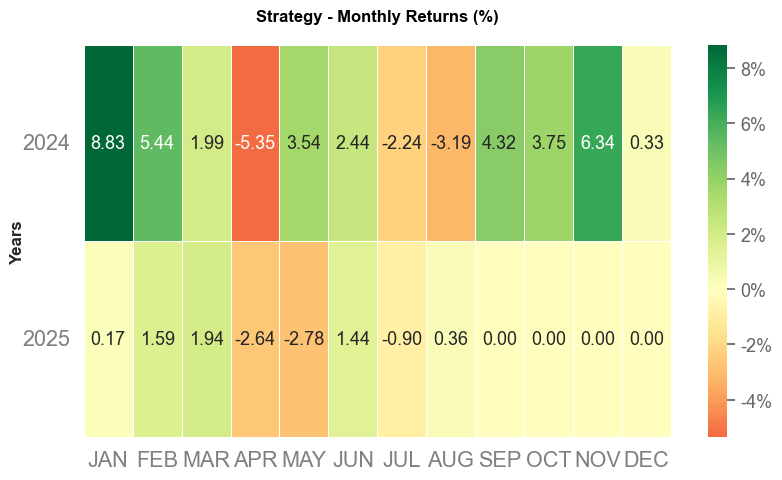

                           Strategy
-------------------------  ----------
Start Period               2024-01-02
End Period                 2025-08-06
Risk-Free Rate             0.0%
Time in Market             99.0%

Cumulative Return          27.21%
CAGR﹪                     10.98%

Sharpe                     1.2
Prob. Sharpe Ratio         92.13%
Smart Sharpe               1.17
Sortino                    1.62
Smart Sortino              1.59
Sortino/√2                 1.15
Smart Sortino/√2           1.12
Omega                      1.2

Max Drawdown               -9.35%
Longest DD Days            114
Volatility (ann.)          14.58%
Calmar                     1.17
Skew                       -0.69
Kurtosis                   0.27

Expected Daily %           0.07%
Expected Monthly %         1.21%
Expected Yearly %          12.79%
Kelly Criterion            10.1%
Risk of Ruin               0.0%
Daily Value-at-Risk        -1.44%
Expected Shortfall (cVaR)  -1.44%

Max Consecutive Wins       1

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2024-04-04,2024-05-02,2024-06-28,86,-9.353962,-8.184629
2,2025-04-15,2025-06-03,2025-08-06,114,-9.066211,-8.627624
3,2024-07-02,2024-09-12,2024-10-03,94,-7.909910,-7.881806
4,2024-12-09,2025-01-07,2025-02-24,78,-7.793754,-7.349030
5,2025-02-26,2025-03-10,2025-03-24,27,-5.191007,-4.887618


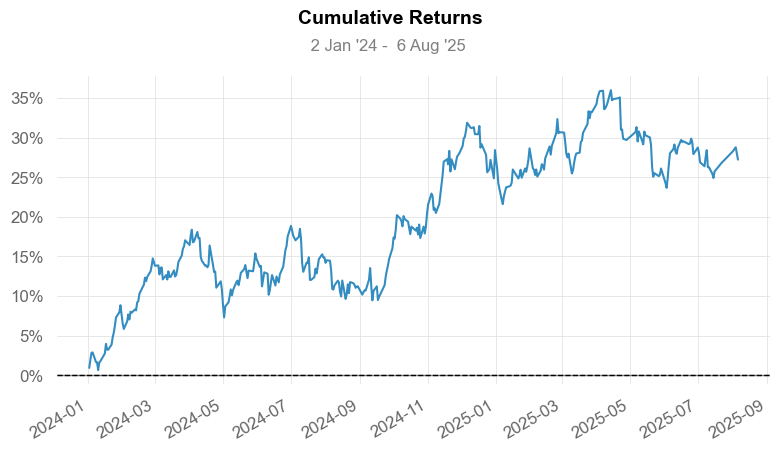

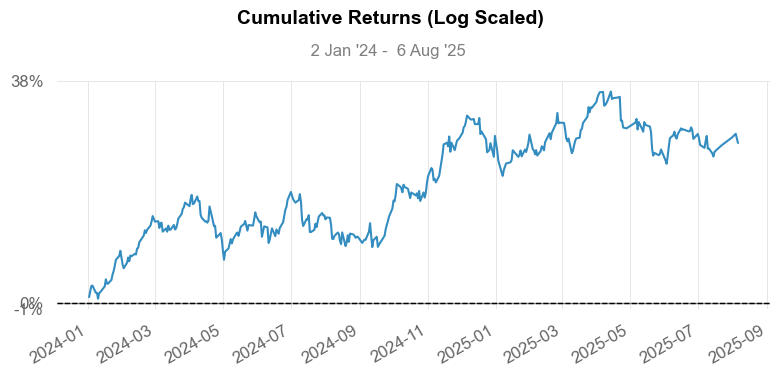

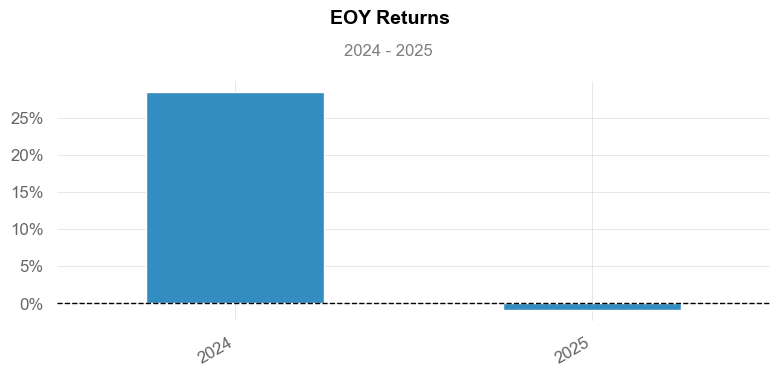

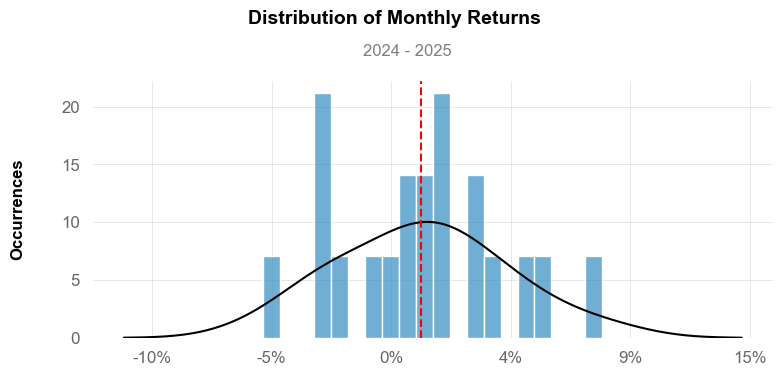

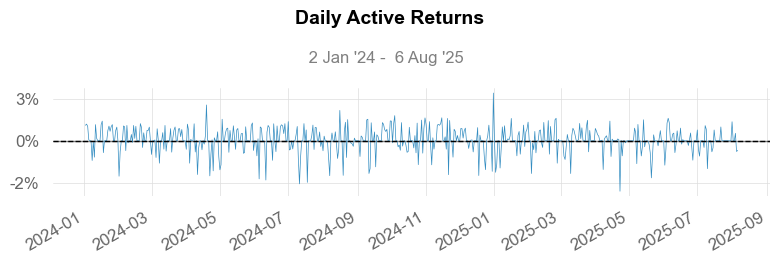

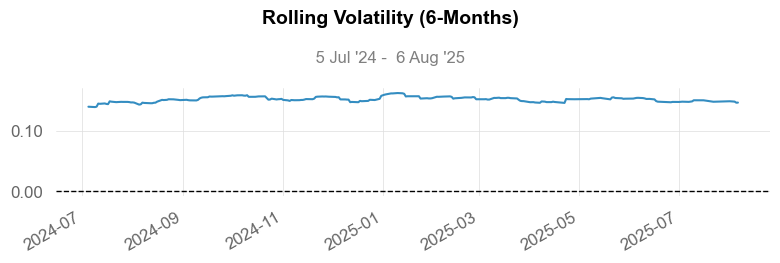

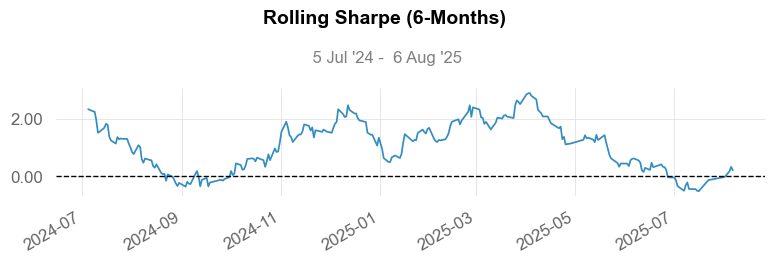

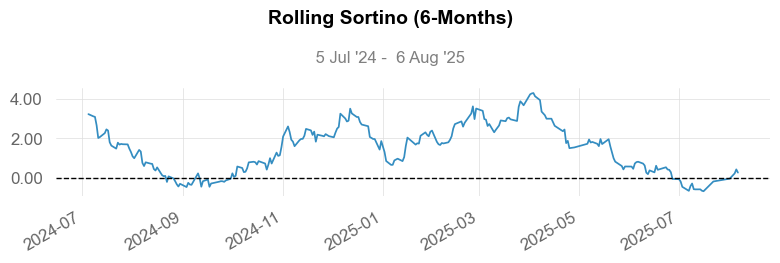

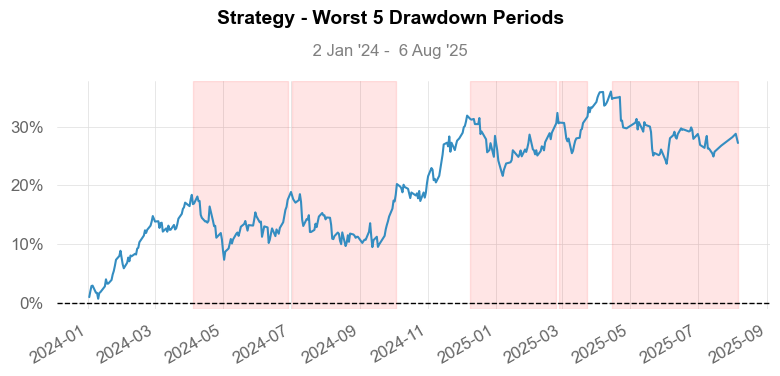

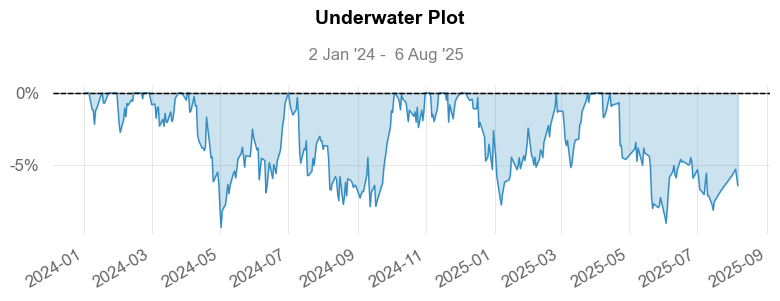

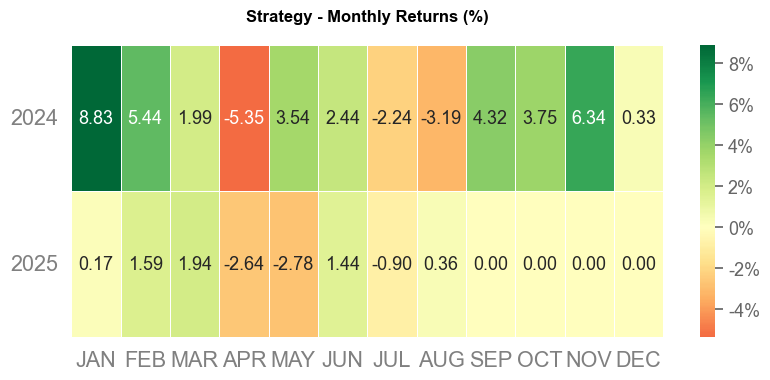

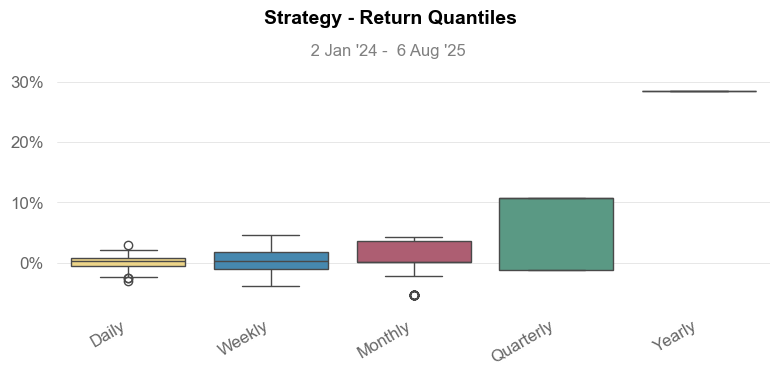

In [19]:
df_trades2.index = pd.to_datetime(df_trades2.index)
df_trades2["return"] = df_trades2["combined_pnl"]/50000
qs.plots.monthly_heatmap(df_trades2["return"])
qs.reports.full(df_trades2["return"])

In [39]:
fig = go.Figure()
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Ohlc(x = ohlc_df.index , open = ohlc_df["Open"]
                               ,high = ohlc_df["High"] , low = ohlc_df['Low'],
                               close = ohlc_df["Close"]), secondary_y=False)

fig.add_hline(y = model_params.period_high)
fig.add_hline(y = model_params.period_low)
# call_line = df1.CE_5990_0_W_ltp.resample("2min").mean().reindex(ohlc_df.index,method = "ffill")
# put_line = df1.PE_6000_0_W_ltp.resample("2min").mean().reindex(ohlc_df.index,method = "ffill")

# fig.add_trace(go.Scatter(x = ohlc_df.index,y = call_line,mode="lines",line=dict(color="blue", width=1)), secondary_y=True)
# fig.add_trace(go.Scatter(x = ohlc_df.index,y = put_line,mode="lines",line=dict(color="green", width=1)), secondary_y=True)
fig.update_layout(
    title="OHLC Chart ",
    xaxis_title="Date",
    yaxis_title="Price",
    xaxis_rangeslider_visible=False # hides the range slider
)
fig.show()
